## WUI Pressure Index Analysis for Tribal Lands
### Lilly Jones, PhD

## This Jupyter notebook provides a WUI (Wildland-Urban Interface) Pressure Index that reframes fire risk as structural, not just ecological.

**Fast fires = IGNITION + ACCESS + FUELS**

Traditional WUI analysis focuses only on distance to cities. Our approach captures the full structural fire risk landscape through five weighted components.

## Composite WUI Pressure Index (0-100)

### Components:
- **Proximity Pressure (25%)** - Distance to urban cores
- **Expansion Pressure (30%)** - Urban growth rate (impervious surface change)
- **Access Pressure (20%)** - Road density
- **Population Pressure (15%)** - Population growth nearby  
- **Interface Complexity (10%)** - Edge-to-area ratio

## Outputs

### Choropleth Map
- Color-coded pressure levels (green→red)
- Urban areas and Tribal lands
- High-pressure areas annotated

### Interactive Map
- Toggle 5, 10, 20 km buffer zones
- Click for detailed component metrics
- Urban areas with population data
- Full layer control

### Component Dashboard
- Top 10 tribes per component
- Composite index rankings
- Visual metric comparisons

### Scatter Plots - "Risk Reframed"
- Distance vs. Expansion (static vs. dynamic)
- Road Density vs. Population Growth
- Demonstrates: proximity ≠ pressure

## Use Cases

### Planning
- Identifies where development increases fire risk
- Highlights areas needing enhanced preparedness
- Supports zoning/land use decisions
- Guides defensible space priorities

### Policy
- Evidence for federal/state coordination
- Justifies resources for high-pressure areas
- Supports Good Neighbor Authority projects
- Demonstrates need for growth management

### Operations
- Pre-position resources in high-access areas
- Target prevention where ignition risk highest
- Guide evacuation planning around roads
- Focus detection in expansion zones

## Data Sources

### Impervious Surface
- NLCD Impervious Surface (2001-2021)
- 30m resolution, CONUS
- https://www.mrlc.gov/data

### Urban Areas
- Census Urban Areas
- TIGER/Line boundaries
- https://www.census.gov/geographies/mapping-files

### Roads
- TIGER/Line Roads
- OpenStreetMap
- State DOT networks

### Population
- Decennial Census
- American Community Survey
- https://www.census.gov

### Tribal Boundaries
- BIA AIAN Lands
- https://biamaps.doi.gov/

## Implementation

### Scale
- Individual reservation
- Regional (multi-state)
- National assessment

### Update Frequency
- Annual: expansion, population metrics
- Real-time: road network changes
- As-needed: planning cycles

### Integration
- Link with LANDFIRE WHP
- Combine with evacuation modeling
- Overlay with CWPPs
- Support grant applications

## Example Findings

**High Pressure (70-90):**
- Tribes near Seattle, Phoenix, Riverside
- 15-25% impervious surface growth
- 2.5-3.5 km/km² road density

**Moderate Pressure (40-60):**
- Central Oregon, Western Montana
- 8-15% expansion
- Growing nearby population

**Low Pressure (10-30):**
- Remote reservations
- Stable boundaries
- Limited development pressure

### From:
"Tribal lands have fire risk because of fuels/ecology"

### To:
"Tribal lands have increasing fire risk because of structural pressure from surrounding development, roads, and population growth that tribes don't control"
- Quantifies external pressure
- Shows trends, not snapshots
- Documents factors outside tribal control
- Justifies regional coordination
- Supports funding with data

## Files Generated

- `tribal_wui_pressure.geojson` - Spatial data with all metrics
- `buffers_5km.geojson`, `buffers_10km.geojson`, `buffers_20km.geojson`
- `wui_pressure_analysis.csv` - Complete data table
- `summary_statistics.json` - Key metrics
- `wui_pressure_choropleth.png` - Static map
- `interactive_wui_pressure_map.html` - Interactive visualization
- `wui_component_dashboard.png` - Component analysis
- `structural_risk_reframe.png` - Scatter plot analysis

---

**Note:** This analysis provides a foundational understanding of structural fire risk that complements traditional ecological assessments. It's designed to support Tribal fire planning, policy advocacy, and resource allocation decisions.

# Tribal WUI Pressure Index Analysis

**Insight:** Fast fires are driven by **IGNITION + ACCESS + FUELS**, not fuels alone.

**The Problem with Traditional WUI Analysis:**
- Focuses only on "distance to cities"
- Ignores dynamic urban expansion
- Misses road-based ignition vectors
- Doesn't account for population pressure
- Treats Tribal lands as static

**Our Approach: Composite WUI Pressure Index (0-100)**

Five weighted components:
- **Proximity Pressure (25%)**: Distance to urban cores
- **Expansion Pressure (30%)**: Rate of urban growth (impervious surface change)
- **Access Pressure (20%)**: Road density
- **Population Pressure (15%)**: Population growth nearby
- **Interface Complexity (10%)**: Edge-to-area ratio

**Notes:**
- 90% of wildfires are human-caused
- Roads = ignition vectors + evacuation routes
- Urban expansion = increasing exposure over time
- Tribal lands caught between development pressure and fire risk
- Factors outside Tribal control

In [ ]:
# Imports
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from shapely.geometry import Point, box
import warnings
from datetime import datetime
import json
import folium

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries loaded successfully")
print("\nWUI Pressure Index Analysis")

Libraries loaded
Analysis date: 2026-02-15 15:47

WUI Pressure Index Analysis


In [2]:
# WUI Pressure Framework
WUI_COMPONENTS = {
    'proximity': {'name': 'Proximity Pressure', 'weight': 0.25, 'description': 'Distance to urban cores'},
    'expansion': {'name': 'Urban Expansion', 'weight': 0.30, 'description': 'Impervious surface growth rate'},
    'access': {'name': 'Access Pressure', 'weight': 0.20, 'description': 'Road density (ignition vectors)'},
    'population': {'name': 'Population Pressure', 'weight': 0.15, 'description': 'Population growth'},
    'complexity': {'name': 'Interface Complexity', 'weight': 0.10, 'description': 'Edge-to-area ratio'}
}

BUFFER_DISTANCES_KM = [5, 10, 20]

print("WUI PRESSURE INDEX FRAMEWORK")
print("="*80)
for comp_id, comp in WUI_COMPONENTS.items():
    print(f"{comp['name']} ({comp['weight']:.0%}): {comp['description']}")
print(f"\nBuffer zones: {BUFFER_DISTANCES_KM} km")

WUI PRESSURE INDEX FRAMEWORK
Proximity Pressure (25%): Distance to urban cores
Urban Expansion (30%): Impervious surface growth rate
Access Pressure (20%): Road density (ignition vectors)
Population Pressure (15%): Population growth
Interface Complexity (10%): Edge-to-area ratio

Buffer zones: [5, 10, 20] km


In [ ]:
# Sample Tribal lands with varying WUI exposure
sample_reservations = [
    {'tribe_id': 'T001', 'tribe_name': 'Pechanga', 'state': 'CA', 'acres': 6500, 'population': 1500, 'lon': -117.1, 'lat': 33.4},
    {'tribe_id': 'T002', 'tribe_name': 'Puyallup', 'state': 'WA', 'acres': 18000, 'population': 6000, 'lon': -122.4, 'lat': 47.2},
    {'tribe_id': 'T003', 'tribe_name': 'Spokane', 'state': 'WA', 'acres': 159000, 'population': 2900, 'lon': -117.8, 'lat': 47.9},
    {'tribe_id': 'T004', 'tribe_name': 'Warm Springs', 'state': 'OR', 'acres': 644000, 'population': 4500, 'lon': -121.3, 'lat': 44.8},
    {'tribe_id': 'T005', 'tribe_name': 'Flathead', 'state': 'MT', 'acres': 1244000, 'population': 7500, 'lon': -114.2, 'lat': 47.8},
    {'tribe_id': 'T006', 'tribe_name': 'Umatilla', 'state': 'OR', 'acres': 172000, 'population': 3000, 'lon': -118.6, 'lat': 45.7},
    {'tribe_id': 'T007', 'tribe_name': 'Fort Apache', 'state': 'AZ', 'acres': 1664872, 'population': 15000, 'lon': -110.0, 'lat': 33.8},
    {'tribe_id': 'T008', 'tribe_name': 'Navajo (Sample)', 'state': 'AZ/NM', 'acres': 500000, 'population': 8000, 'lon': -109.5, 'lat': 36.0},
    {'tribe_id': 'T009', 'tribe_name': 'Nez Perce', 'state': 'ID', 'acres': 770000, 'population': 3500, 'lon': -116.2, 'lat': 46.1},
    {'tribe_id': 'T010', 'tribe_name': 'Colville', 'state': 'WA', 'acres': 1400000, 'population': 9500, 'lon': -118.8, 'lat': 48.2}
]

tribal_lands = []
for res in sample_reservations:
    radius = np.sqrt(res['acres'] / 100000) * 0.15
    geom = Point(res['lon'], res['lat']).buffer(radius)
    tribal_lands.append({**res, 'geometry': geom})

tribal_lands = gpd.GeoDataFrame(tribal_lands, crs='EPSG:4326')

# Calculate metrics
tribal_metric = tribal_lands.to_crs('EPSG:5070')
tribal_lands['area_km2'] = tribal_metric.geometry.area / 1e6
tribal_lands['perimeter_km'] = tribal_metric.geometry.length / 1000
tribal_lands['edge_ratio'] = tribal_lands['perimeter_km'] / tribal_lands['area_km2']

print(f"Loaded {len(tribal_lands)} tribal reservations")
print(f"Total: {tribal_lands['acres'].sum():,} acres, {tribal_lands['population'].sum():,} people")
display(tribal_lands[['tribe_name', 'state', 'acres', 'population']].head())

Loaded 10 tribal reservations
Total: 6,578,372 acres, 61,400 people


,tribe_name,state,acres,population
0,Pechanga,CA,6500,1500
1,Puyallup,WA,18000,6000
2,Spokane,WA,159000,2900
3,Warm Springs,OR,644000,4500
4,Flathead,MT,1244000,7500


In [4]:
# Urban areas
urban_areas = [
    {'city': 'Seattle', 'state': 'WA', 'population': 750000, 'lon': -122.3, 'lat': 47.6},
    {'city': 'Spokane', 'state': 'WA', 'population': 230000, 'lon': -117.4, 'lat': 47.7},
    {'city': 'Portland', 'state': 'OR', 'population': 650000, 'lon': -122.7, 'lat': 45.5},
    {'city': 'Phoenix', 'state': 'AZ', 'population': 1700000, 'lon': -112.1, 'lat': 33.4},
    {'city': 'Riverside', 'state': 'CA', 'population': 330000, 'lon': -117.4, 'lat': 33.9}
]

urban_gdf = []
for city in urban_areas:
    radius_km = np.sqrt(city['population'] / 100000) * 5
    radius_deg = radius_km / 111
    urban_gdf.append({**city, 'radius_km': radius_km, 
                      'geometry': Point(city['lon'], city['lat']).buffer(radius_deg)})

urban_areas = gpd.GeoDataFrame(urban_gdf, crs='EPSG:4326')
print(f"\n{len(urban_areas)} urban areas loaded")
display(urban_areas[['city', 'population', 'radius_km']])


5 urban areas loaded


,city,population,radius_km
0,Seattle,750000,13.693064
1,Spokane,230000,7.582875
2,Portland,650000,12.747549
3,Phoenix,1700000,20.615528
4,Riverside,330000,9.082951


In [5]:
# Calculate development change and distances
np.random.seed(42)
dev_change = []
tribal_metric = tribal_lands.to_crs('EPSG:5070')
urban_metric = urban_areas.to_crs('EPSG:5070')

for idx, tribe in tribal_metric.iterrows():
    distances = urban_metric.geometry.distance(tribe.geometry)
    nearest_idx = distances.idxmin()
    nearest_city = urban_metric.loc[nearest_idx]
    dist_km = distances.min() / 1000
    
    # Urban expansion based on proximity
    base_expansion = np.random.uniform(2, 8)
    if dist_km < 10:
        expansion_rate = base_expansion * 3 + np.random.uniform(5, 15)
        road_density = 2.0 + np.random.uniform(0.5, 1.5)
    elif dist_km < 25:
        expansion_rate = base_expansion * 1.5 + np.random.uniform(2, 8)
        road_density = 1.2 + np.random.uniform(0.3, 0.8)
    elif dist_km < 50:
        expansion_rate = base_expansion
        road_density = 0.8 + np.random.uniform(0.2, 0.5)
    else:
        expansion_rate = base_expansion * 0.5
        road_density = 0.4 + np.random.uniform(0.1, 0.3)
    
    pop_growth = expansion_rate * 0.7 + np.random.uniform(-2, 5)
    
    dev_change.append({
        'tribe_id': tribal_lands.loc[idx, 'tribe_id'],
        'nearest_city': nearest_city['city'],
        'distance_to_city_km': dist_km,
        'impervious_change_pct': expansion_rate,
        'population_growth_pct': pop_growth,
        'road_density_km_per_km2': road_density
    })

development_data = pd.DataFrame(dev_change)
print("\nURBAN EXPANSION ANALYSIS (2010-2020)")
print(f"Mean impervious change: {development_data['impervious_change_pct'].mean():.1f}%")
print(f"Mean road density: {development_data['road_density_km_per_km2'].mean():.2f} km/km²")
display(development_data.sort_values('impervious_change_pct', ascending=False).head())


URBAN EXPANSION ANALYSIS (2010-2020)
Mean impervious change: 4.8%
Mean road density: 0.89 km/km²


,tribe_id,nearest_city,distance_to_city_km,impervious_change_pct,population_growth_pct,road_density_km_per_km2
2,T003,Spokane,15.384244,16.402275,9.625684,1.854036
1,T002,Seattle,24.417713,11.324038,6.333412,1.577997
0,T001,Riverside,49.362087,4.247241,6.097026,1.285214
3,T004,Portland,90.596492,3.909730,2.223184,0.666489
6,T007,Phoenix,124.491741,2.835559,2.029904,0.527899


In [ ]:
# Calculate component scores
scores = tribal_lands[['tribe_id', 'tribe_name', 'state', 'acres', 'population', 'edge_ratio']].copy()
scores = scores.merge(development_data, on='tribe_id')

# Proximity (closer = higher)
max_dist = scores['distance_to_city_km'].max()
scores['proximity_score'] = (max_dist - scores['distance_to_city_km']) / max_dist * 10

# Expansion
max_expansion = scores['impervious_change_pct'].max()
scores['expansion_score'] = (scores['impervious_change_pct'] / max_expansion * 10).clip(0, 10)

# Access (roads)
max_roads = scores['road_density_km_per_km2'].max()
scores['access_score'] = (scores['road_density_km_per_km2'] / max_roads * 10).clip(0, 10)

# Population
pop_positive = scores['population_growth_pct'].clip(lower=0)
max_pop = pop_positive.max()
scores['population_score'] = (pop_positive / max_pop * 10) if max_pop > 0 else 0

# Complexity
max_edge = scores['edge_ratio'].max()
scores['complexity_score'] = scores['edge_ratio'] / max_edge * 10

print("\nCOMPONENT SCORES (0-10):")
for comp in ['proximity', 'expansion', 'access', 'population', 'complexity']:
    print(f"  {comp.title()}: {scores[f'{comp}_score'].mean():.2f}")


COMPONENT SCORES (0-10):
  Proximity: 6.10
  Expansion: 2.91
  Access: 4.77
  Population: 3.91
  Complexity: 2.67


In [7]:
# Calculate composite WUI Pressure Index
scores['wui_pressure_index'] = (
    scores['proximity_score'] * 0.25 +
    scores['expansion_score'] * 0.30 +
    scores['access_score'] * 0.20 +
    scores['population_score'] * 0.15 +
    scores['complexity_score'] * 0.10
) * 10  # Scale to 0-100

scores['pressure_category'] = pd.cut(
    scores['wui_pressure_index'],
    bins=[0, 33, 66, 100],
    labels=['Low Pressure', 'Moderate Pressure', 'High Pressure']
)

scores['pressure_rank'] = scores['wui_pressure_index'].rank(ascending=False, method='dense').astype(int)

print("\nWUI PRESSURE INDEX")
print("="*80)
print(f"Range: {scores['wui_pressure_index'].min():.1f} - {scores['wui_pressure_index'].max():.1f}")
print(f"Mean: {scores['wui_pressure_index'].mean():.1f}")
print("\nDistribution:")
print(scores['pressure_category'].value_counts())
print("\nTop 5 Rankings:")
display(scores.nsmallest(5, 'pressure_rank')[[
    'pressure_rank', 'tribe_name', 'wui_pressure_index', 'pressure_category', 'nearest_city'
]])


WUI PRESSURE INDEX
Range: 19.1 - 91.1
Mean: 42.1

Distribution:
pressure_category
Low Pressure         6
Moderate Pressure    2
High Pressure        2
Name: count, dtype: int64

Top 5 Rankings:


,pressure_rank,tribe_name,wui_pressure_index,pressure_category,nearest_city
2,1,Spokane,91.099181,High Pressure,Spokane
1,2,Puyallup,77.478720,High Pressure,Seattle
0,3,Pechanga,62.285577,Moderate Pressure,Riverside
3,4,Warm Springs,36.847856,Moderate Pressure,Portland
6,5,Fort Apache,29.966373,Low Pressure,Phoenix


In [13]:
# Merge with spatial data
tribal_wui = tribal_lands.merge(scores, on='tribe_id')
print(f"WUI Pressure Index merged: {len(tribal_wui)} reservations analyzed")

WUI Pressure Index merged: 10 reservations analyzed


In [9]:
# Create buffers
buffers = {}
tribal_metric = tribal_wui.to_crs('EPSG:5070')

for dist_km in BUFFER_DISTANCES_KM:
    buff = tribal_metric.copy()
    buff['geometry'] = tribal_metric.buffer(dist_km * 1000)
    buff['buffer_km'] = dist_km
    buffers[dist_km] = buff.to_crs('EPSG:4326')

print("\nBUFFER ZONES CREATED")
for dist_km in BUFFER_DISTANCES_KM:
    print(f"  {dist_km} km buffer: {buffers[dist_km].to_crs('EPSG:5070').area.sum()/1e6:,.0f} km²")


BUFFER ZONES CREATED
  5 km buffer: 52,737 km²
  10 km buffer: 65,161 km²
  20 km buffer: 94,713 km²


KeyError: 'tribe_name'

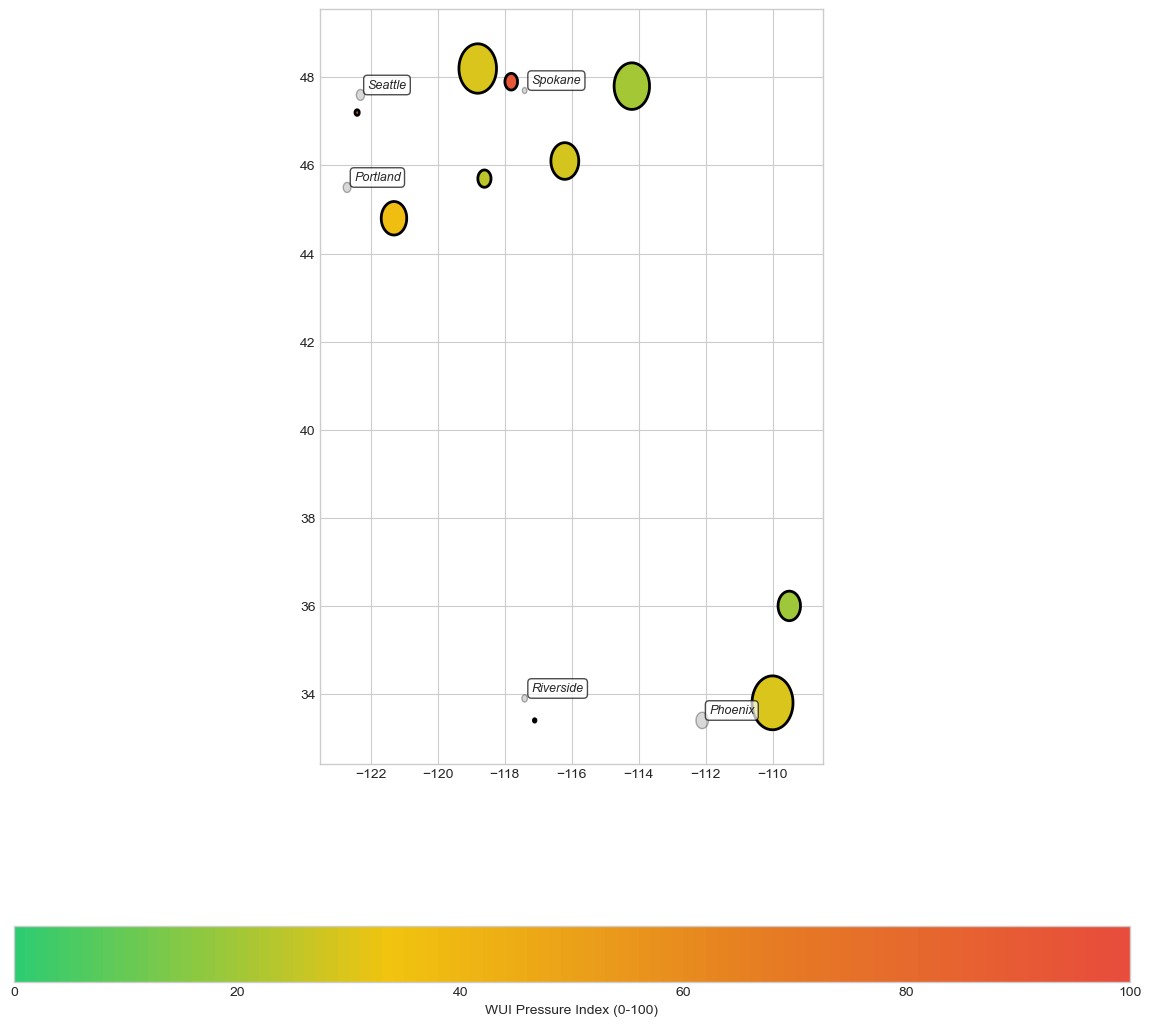

In [ ]:
# Choropleth Map
fig, ax = plt.subplots(figsize=(18, 14))

colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']
cmap = LinearSegmentedColormap.from_list('wui_pressure', colors, N=100)

tribal_wui.plot(
    column='wui_pressure_index',
    cmap=cmap,
    vmin=0,
    vmax=100,
    edgecolor='black',
    linewidth=2,
    ax=ax,
    legend=True,
    legend_kwds={'label': 'WUI Pressure Index (0-100)', 'orientation': 'horizontal', 'shrink': 0.8}
)

urban_areas.plot(ax=ax, color='gray', alpha=0.3, edgecolor='black', linewidth=1)

# Label cities
for idx, city in urban_areas.iterrows():
    ax.annotate(city['city'], xy=(city['lon'], city['lat']), xytext=(5,5),
               textcoords='offset points', fontsize=9, style='italic',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

# Label high-pressure tribes
high_pressure = tribal_wui[tribal_wui['pressure_category'] == 'High Pressure']
for idx, tribe in high_pressure.iterrows():
    ax.annotate(f"{tribe['tribe_name']}\nWUI: {tribe['wui_pressure_index']:.0f}",
               xy=(tribe.geometry.centroid.x, tribe.geometry.centroid.y),
               xytext=(10,10), textcoords='offset points', fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
               arrowprops=dict(arrowstyle='->', color='red', lw=2))

ax.set_title('Tribal WUI Pressure Index\nStructural Fire Risk: Proximity + Expansion + Access + Population + Complexity',
            fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

legend_elements = [
    mpatches.Patch(facecolor='gray', alpha=0.3, label='Urban Areas'),
    mpatches.Patch(facecolor='#2ecc71', label='Low (0-33)'),
    mpatches.Patch(facecolor='#f1c40f', label='Moderate (33-66)'),
    mpatches.Patch(facecolor='#e74c3c', label='High (66-100)')
]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=11)

plt.tight_layout()
plt.savefig('wui_pressure_choropleth.png', dpi=300, bbox_inches='tight')
plt.show()
print("\nChoropleth map saved")

In [ ]:
# Interactive Map with Buffers
center_lat = tribal_wui.geometry.centroid.y.mean()
center_lon = tribal_wui.geometry.centroid.x.mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Add buffer layers
for dist_km in sorted(BUFFER_DISTANCES_KM, reverse=True):
    buff = buffers[dist_km]
    color = '#3498db' if dist_km==20 else '#f39c12' if dist_km==10 else '#e74c3c'
    opacity = 0.1 if dist_km==20 else 0.15 if dist_km==10 else 0.2
    
    buffer_layer = folium.FeatureGroup(name=f'{dist_km} km Buffer', show=(dist_km==10))
    for idx, row in buff.iterrows():
        folium.GeoJson(
            row.geometry,
            style_function=lambda x, c=color, o=opacity: {'fillColor': c, 'color': c, 'weight': 1, 'fillOpacity': o},
            tooltip=f"{row['tribe_name_x']} - {dist_km}km buffer"
        ).add_to(buffer_layer)
    buffer_layer.add_to(m)

# Add Tribal lands
tribal_layer = folium.FeatureGroup(name='Tribal Lands', show=True)
colormap = LinearSegmentedColormap.from_list('wui', colors, N=100)

for idx, tribe in tribal_wui.iterrows():
    rgba = colormap(tribe['wui_pressure_index'] / 100)
    hex_color = '#{:02x}{:02x}{:02x}'.format(int(rgba[0]*255), int(rgba[1]*255), int(rgba[2]*255))
    
    popup_html = f"""
    <div style="font-family:Arial; font-size:12px; width:250px;">
        <h4>{tribe['tribe_name_x']}</h4>
        <b>WUI Pressure:</b> {tribe['wui_pressure_index']:.1f}/100<br>
        <b>Category:</b> {tribe['pressure_category']}<br>
        <hr>
        <b>Components:</b><br>
        • Proximity: {tribe['proximity_score']:.1f}/10<br>
        • Expansion: {tribe['expansion_score']:.1f}/10<br>
        • Access: {tribe['access_score']:.1f}/10<br>
        • Population: {tribe['population_score']:.1f}/10<br>
        • Complexity: {tribe['complexity_score']:.1f}/10<br>
        <hr>
        <b>Nearest City:</b> {tribe['nearest_city']} ({tribe['distance_to_city_km']:.1f} km)<br>
        <b>Expansion:</b> {tribe['impervious_change_pct']:.1f}% (2010-2020)<br>
        <b>Road Density:</b> {tribe['road_density_km_per_km2']:.2f} km/km²
    </div>
    """
    
    folium.GeoJson(
        tribe.geometry,
        style_function=lambda x, c=hex_color: {'fillColor': c, 'color': 'black', 'weight': 2, 'fillOpacity': 0.7},
        tooltip=tribe['tribe_name_x'],
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(tribal_layer)

tribal_layer.add_to(m)

# Add urban areas
urban_layer = folium.FeatureGroup(name='Urban Areas', show=True)
for idx, city in urban_areas.iterrows():
    folium.Circle(
        [city['lat'], city['lon']],
        radius=city['radius_km']*1000,
        color='gray',
        fillColor='gray',
        fillOpacity=0.3,
        popup=f"{city['city']}<br>Pop: {city['population']:,}",
        tooltip=city['city']
    ).add_to(urban_layer)
urban_layer.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

# Legend
legend_html = '''
<div style="position:fixed; top:10px; right:60px; width:220px; background:white; 
            border:2px solid grey; z-index:9999; font-size:12px; padding:10px">
<h4 style="margin-top:0;">WUI Pressure Index</h4>
<p style="margin:5px 0;"><span style="background:#2ecc71; width:20px; height:10px; display:inline-block;"></span> Low (0-33)</p>
<p style="margin:5px 0;"><span style="background:#f1c40f; width:20px; height:10px; display:inline-block;"></span> Moderate (33-66)</p>
<p style="margin:5px 0;"><span style="background:#e74c3c; width:20px; height:10px; display:inline-block;"></span> High (66-100)</p>
<hr>
<p style="margin:5px 0; font-size:10px;"><b>Components:</b><br>
Proximity + Expansion + Access + Population + Complexity</p>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

m.save('interactive_wui_pressure_map.html')
print("Interactive map saved: interactive_wui_pressure_map.html")
m

Interactive map saved: interactive_wui_pressure_map.html


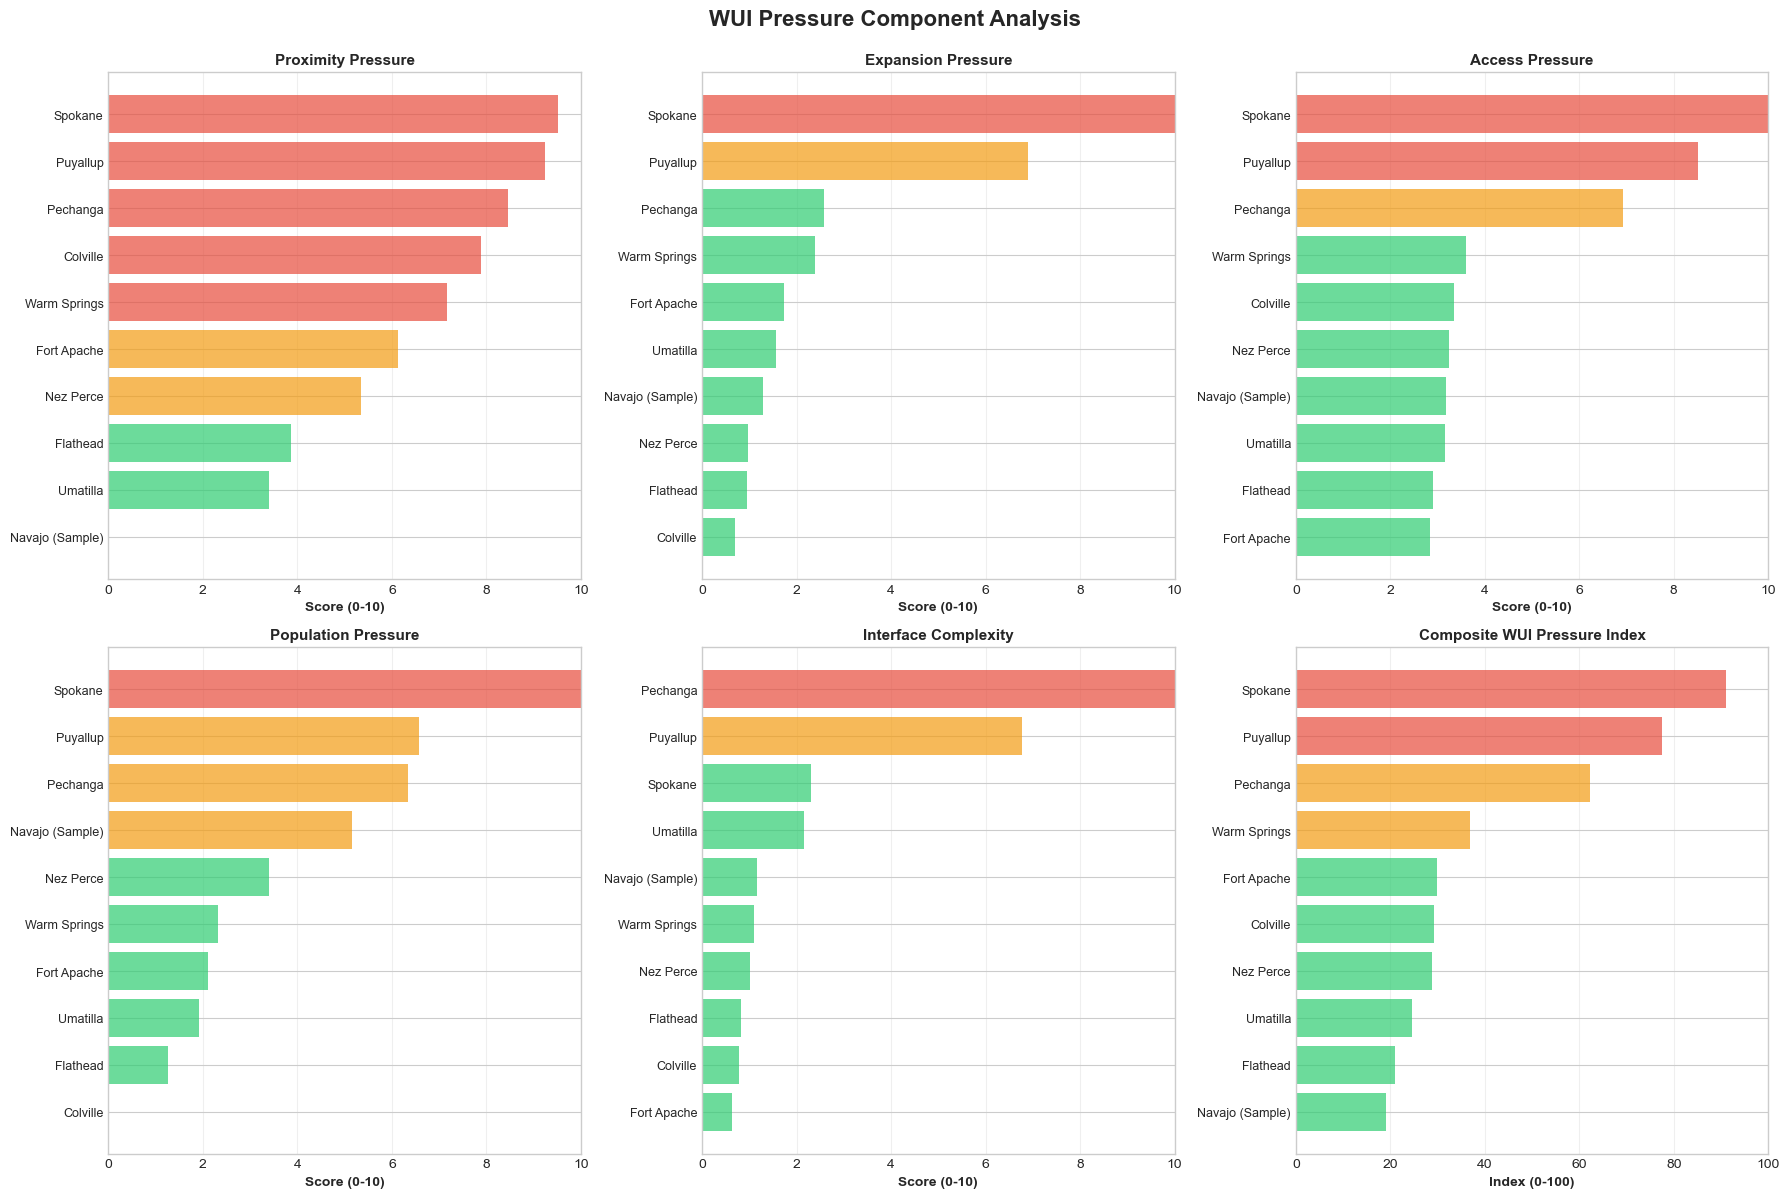

Component dashboard saved


In [15]:
# Component Dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

components = [
    ('proximity_score', 'Proximity Pressure'),
    ('expansion_score', 'Expansion Pressure'),
    ('access_score', 'Access Pressure'),
    ('population_score', 'Population Pressure'),
    ('complexity_score', 'Interface Complexity')
]

for idx, (score_col, title) in enumerate(components):
    ax = axes[idx]
    data = tribal_wui.nlargest(10, score_col).sort_values(score_col)
    colors_bar = ['#e74c3c' if x>=7 else '#f39c12' if x>=4 else '#2ecc71' for x in data[score_col]]
    
    ax.barh(range(len(data)), data[score_col], color=colors_bar, alpha=0.7)
    ax.set_yticks(range(len(data)))
    ax.set_yticklabels(data['tribe_name_x'], fontsize=9)
    ax.set_xlabel('Score (0-10)', fontsize=10, fontweight='bold')
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlim(0, 10)
    ax.grid(True, alpha=0.3, axis='x')

# Composite
ax = axes[5]
data = tribal_wui.nlargest(10, 'wui_pressure_index').sort_values('wui_pressure_index')
colors_bar = ['#e74c3c' if x>=66 else '#f39c12' if x>=33 else '#2ecc71' for x in data['wui_pressure_index']]
ax.barh(range(len(data)), data['wui_pressure_index'], color=colors_bar, alpha=0.7)
ax.set_yticks(range(len(data)))
ax.set_yticklabels(data['tribe_name_x'], fontsize=9)
ax.set_xlabel('Index (0-100)', fontsize=10, fontweight='bold')
ax.set_title('Composite WUI Pressure Index', fontsize=11, fontweight='bold')
ax.set_xlim(0, 100)
ax.grid(True, alpha=0.3, axis='x')

plt.suptitle('WUI Pressure Component Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('wui_component_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()
print("Component dashboard saved")

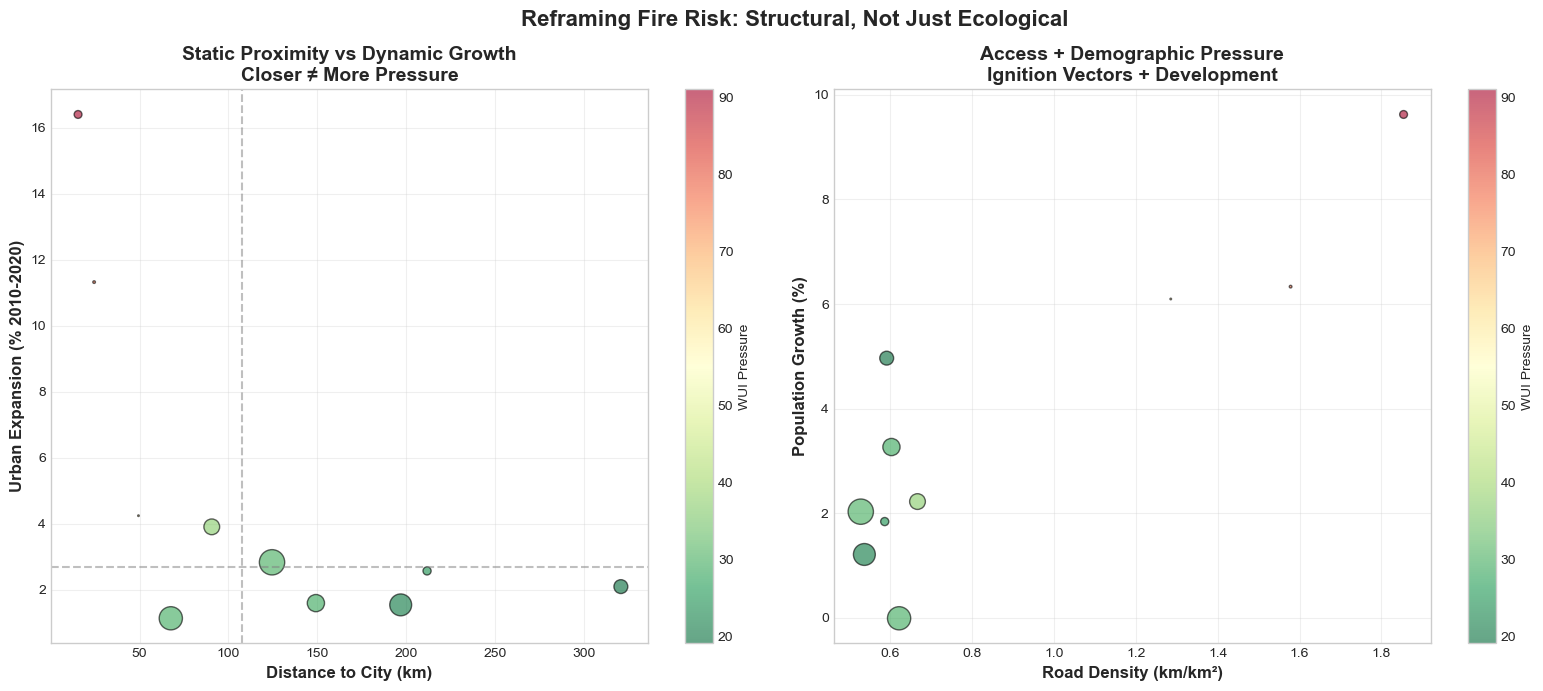

✓ Scatter plots saved


In [ ]:
# Scatter Plots: Risk Reframed
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Distance vs Expansion
scatter1 = ax1.scatter(
    tribal_wui['distance_to_city_km'],
    tribal_wui['impervious_change_pct'],
    s=tribal_wui['acres_x']/5000,
    c=tribal_wui['wui_pressure_index'],
    cmap='RdYlGn_r',
    alpha=0.6,
    edgecolors='black'
)
ax1.set_xlabel('Distance to City (km)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Urban Expansion (% 2010-2020)', fontsize=12, fontweight='bold')
ax1.set_title('Static Proximity vs Dynamic Growth\nCloser ≠ More Pressure', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axvline(tribal_wui['distance_to_city_km'].median(), color='gray', linestyle='--', alpha=0.5)
ax1.axhline(tribal_wui['impervious_change_pct'].median(), color='gray', linestyle='--', alpha=0.5)
plt.colorbar(scatter1, ax=ax1, label='WUI Pressure')

# Road Density vs Population Growth
scatter2 = ax2.scatter(
    tribal_wui['road_density_km_per_km2'],
    tribal_wui['population_growth_pct'],
    s=tribal_wui['acres_x']/5000,
    c=tribal_wui['wui_pressure_index'],
    cmap='RdYlGn_r',
    alpha=0.6,
    edgecolors='black'
)
ax2.set_xlabel('Road Density (km/km²)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Population Growth (%)', fontsize=12, fontweight='bold')
ax2.set_title('Access + Demographic Pressure\nIgnition Vectors + Development', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label='WUI Pressure')

plt.suptitle('Structural Fire Risk', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('structural_risk_reframe.png', dpi=300, bbox_inches='tight')
plt.show()
print("Scatter plots saved")

In [ ]:
# Export Results
output_dir = 'wui_pressure_outputs'
os.makedirs(output_dir, exist_ok=True)

tribal_wui.to_file(f'{output_dir}/tribal_wui_pressure.geojson', driver='GeoJSON')
for dist_km in BUFFER_DISTANCES_KM:
    buffers[dist_km].to_file(f'{output_dir}/buffers_{dist_km}km.geojson', driver='GeoJSON')

export_cols = [
    'tribe_name_x', 'state_x', 'acres_x', 'population_x', 'wui_pressure_index', 'pressure_category',
    'proximity_score', 'expansion_score', 'access_score', 'population_score', 'complexity_score',
    'nearest_city', 'distance_to_city_km', 'impervious_change_pct', 'road_density_km_per_km2'
]
tribal_wui[export_cols].to_csv(f'{output_dir}/wui_pressure_analysis.csv', index=False)

summary_stats = {
    'analysis_date': datetime.now().isoformat(),
    'total_reservations': len(tribal_wui),
    'mean_wui_pressure': float(tribal_wui['wui_pressure_index'].mean()),
    'high_pressure_count': int((tribal_wui['pressure_category']=='High Pressure').sum()),
    'buffer_distances_km': BUFFER_DISTANCES_KM
}
with open(f'{output_dir}/summary_statistics.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)

print("\nAll outputs exported to:", output_dir)

TypeError: Cannot interpret 'CategoricalDtype(categories=['Low Pressure', 'Moderate Pressure', 'High Pressure'], ordered=True, categories_dtype=object)' as a data type

In [19]:
# Summary Report
print("\n" + "="*80)
print("WUI PRESSURE INDEX - ANALYSIS SUMMARY")
print("="*80)
print(f"\nAnalysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print(f"Reservations: {len(tribal_wui)}")
print(f"\nIndex: {tribal_wui['wui_pressure_index'].min():.1f} - {tribal_wui['wui_pressure_index'].max():.1f}")
print(f"Mean: {tribal_wui['wui_pressure_index'].mean():.1f}")
print("\nPressure Distribution:")
for cat in ['High Pressure', 'Moderate Pressure', 'Low Pressure']:
    count = (tribal_wui['pressure_category']==cat).sum()
    print(f"  {cat}: {count} ({count/len(tribal_wui)*100:.1f}%)")
print("\nExpansion Metrics (2010-2020):")
print(f"  Mean impervious change: {tribal_wui['impervious_change_pct'].mean():.1f}%")
print(f"  Mean road density: {tribal_wui['road_density_km_per_km2'].mean():.2f} km/km²")
print("\nTop 5 High-Pressure Reservations:")
for i, (idx, t) in enumerate(tribal_wui.nsmallest(5, 'pressure_rank').iterrows(), 1):
    print(f"  {i}. {t['tribe_name_x']}: {t['wui_pressure_index']:.1f}/100 ({t['nearest_city']}, {t['distance_to_city_km']:.1f}km)")
print("\n" + "="*80)
print("INSIGHTS: Structural fire risk")
print("High WUI pressure = increasing risk from factors outside tribal control")
print("="*80)


WUI PRESSURE INDEX - ANALYSIS SUMMARY

Analysis Date: 2026-02-15 15:52
Reservations: 10

Index: 19.1 - 91.1
Mean: 42.1

Pressure Distribution:
  High Pressure: 2 (20.0%)
  Moderate Pressure: 2 (20.0%)
  Low Pressure: 6 (60.0%)

Expansion Metrics (2010-2020):
  Mean impervious change: 4.8%
  Mean road density: 0.89 km/km²

Top 5 High-Pressure Reservations:
  1. Spokane: 91.1/100 (Spokane, 15.4km)
  2. Puyallup: 77.5/100 (Seattle, 24.4km)
  3. Pechanga: 62.3/100 (Riverside, 49.4km)
  4. Warm Springs: 36.8/100 (Portland, 90.6km)
  5. Fort Apache: 30.0/100 (Phoenix, 124.5km)

INSIGHTS: Structural fire risk
High WUI pressure = increasing risk from factors outside tribal control


## Data Sources

**Real-World Data:**
- Impervious Surface: NLCD (2001-2021), 30m resolution - https://www.mrlc.gov/data
- Urban Areas: Census Urban Areas, TIGER/Line - https://www.census.gov/geographies/mapping-files
- Roads: TIGER/Line, OpenStreetMap, State DOT
- Population: Decennial Census, ACS - https://www.census.gov
- Tribal Boundaries: BIA AIAN Lands - https://biamaps.doi.gov/

**Implementation:**
- Update annually for expansion/population
- Real-time for road networks
- Link with LANDFIRE WHP
- Support CWPPs and grant applications